# Modified Fuchs Model Dataset Generation V3.2

### Authors: Ronak Desai, Tom Zhang, and Joe Smith

## Imports and Setting Constants of Notebook

In [1]:
# Imports
import numpy as np
import scipy.special as special
import csv
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from numpy.random import RandomState

# Fixed Seed for Repeatability
seed = 5
np.random.seed(seed)

# Tag to Indicate Description of Dataset
tag = 'v3-2_seed-' + str(seed)

# Number of Data Points and Percentage Gaussian Noise
num_points = 25000
pct_noise = 0

# *******************************************************
#  Adjustable Constants that we tweaked from Fuchs Model*
# *******************************************************
c1=4 # tacc = c1 tFWHM: c1 = 1.3 from Fuchs
c2=0.74 # intensity exponent in hot electron fraction f: c2 = 0.74 from Fuchs
theta=25 # Divergence Angle theta: theta = 25 deg from Fuchs
const_f = False # Don't assume f is fixed at 0.5

## Defined Functions

In [2]:
def calc_laser_energy(I0, w0, tFWHM):
    return (np.pi/2)*I0*w0**2 * tFWHM # For a Sine-Squared Pulse
    #return (np.pi/2)*I0*w0**2 * tFWHM * np.sqrt(np.pi / (4*np.log(2))) # For a Gaussian Shaped Pulse

# integrate dN/dE from eMin to eMax from Eq. (2) in Fuchs Paper
def calc_N_between(ne, cs, tacc, S, Tp, eMin=0, eMax=1):
    xmin = np.sqrt(2*eMin/Tp)
    xmax = np.sqrt(2*eMax/Tp)
    return ne*cs*tacc*S*(np.exp(-xmin) - np.exp(-xmax))

# integrate dN/dE * E from eMin to eMax from Eq. (2) in Fuchs Paper
def calc_E_between(ne, cs, tacc, S, Tp, eMin=0, eMax=1):
    xmin = np.sqrt(2*eMin/Tp)
    xmax = np.sqrt(2*eMax/Tp)
    return ne*cs*tacc*S*Tp/2*(np.exp(-xmin)*(2 + xmin*(2 + xmin)) - np.exp(-xmax)*(2 + xmax*(2 + xmax)))

# Calculate Max proton energy in terms of normalized acceleration time and hot temperature Tp from Eq. (1) in Fuchs Paper
def calc_max_E(omega_pi, tacc, Tp):
    tp = omega_pi*tacc / np.sqrt(2*np.exp(1))
    return 2*Tp*np.log(tp + np.sqrt(tp**2 + 1))**2

def gaussian_noise(energy_list, pct_noise, random_seed = False):
    prng = RandomState(seed)
    α = pct_noise/100 # Fraction instead of percent
    noisy_energy_list = prng.normal(energy_list, energy_list*α)
    for i in range(len(noisy_energy_list)):
        while(noisy_energy_list[i] < 0):
            print('found (-) energy value at i = {} during dataset generation, resampling now ...'.format(i))
            noisy_energy_list[i] = prng.normal(energy_list[i], energy_list[i]*α)
    return noisy_energy_list

def log_gaussian_noise(energy_list, pct_noise, random_seed = False):
    if random_seed:
        prng = RandomState()
    else: 
        prng = RandomState(seed)
    α = pct_noise/100 # Fraction instead of percent
    noisy_energy_list = np.zeros(len(energy_list))
    for i in range(len(noisy_energy_list)):
        mu = np.log(energy_list[i]/np.sqrt(1+α**2))
        σ = np.sqrt(np.log(1+α**2))
        noisy_energy_list[i] = prng.lognormal(mu, σ)
    return noisy_energy_list
    
def fuchs_model(I0, z, d, w0 = 1.5e-6, lmda = 0.8e-6, tFWHM = 40.0e-15, c1 = 1.3, c2 = 0.74, theta = 25, pct_noise = 0, const_f = False):
    c = 2.998e8
    m= 9.109e-31
    e=1.602e-19
    mi=1.673e-27
    Zi=1
    eps0=8.854e-12
    laser_energy = calc_laser_energy(I0, w0, tFWHM)
    
    omega = 2*np.pi*c/lmda
    zR = np.pi * w0**2 / lmda
    theta_rad = theta*np.pi/180
    Iz = I0 / (1 + (z/zR)**2)
    w = w0*np.sqrt(1 + (z/zR)**2)
    E0 = np.sqrt(2*Iz / (c*eps0))
    a0 = (e*E0)/(m*omega*c)
    gamma = np.sqrt(1+a0**2)
    Tp = m*c**2*(gamma - 1)
    if const_f:
        f = 0.5
    else:
        f = np.minimum(1.2e-15 * (Iz*1e-4)**c2, 0.5)
    Ne = f*laser_energy / Tp
    r0 = w * np.sqrt(2*np.log(2))/2
    S = np.pi*(r0 + d*np.tan(theta_rad))**2
    ne = Ne / (S*c*tFWHM)
    omega_pi = np.sqrt(Zi * e**2 *ne / (mi*eps0))
    tacc = c1 * tFWHM

    max_proton_energy = calc_max_E(omega_pi, tacc, Tp)

    cs = np.sqrt(Zi*Tp/mi) # Sound Speed
    num_protons = calc_N_between(ne, cs, tacc, S, Tp, eMin=0, eMax=max_proton_energy)
    total_proton_energy = calc_E_between(ne, cs, tacc, S, Tp, eMin=0, eMax=max_proton_energy)
    average_proton_energy = total_proton_energy/num_protons

    # Convert Energies to MeV
    max_proton_energy_MeV = max_proton_energy / (1.6e-13)
    total_proton_energy_MeV = total_proton_energy / (1.6e-13)
    average_proton_energy_MeV = average_proton_energy / (1.6e-13)
    
    # Laser to Proton Energy Conversion Ratio
    laser_conversion_efficiency = total_proton_energy / laser_energy
    
    # Add Log Gaussian Noise
    noisy_max_proton_energy_MeV = log_gaussian_noise(max_proton_energy_MeV, pct_noise)
    noisy_total_proton_energy_MeV = log_gaussian_noise(total_proton_energy_MeV, pct_noise)
    noisy_average_proton_energy_MeV = log_gaussian_noise(average_proton_energy_MeV, pct_noise)
    
    return (noisy_max_proton_energy_MeV, noisy_total_proton_energy_MeV, noisy_average_proton_energy_MeV,
            laser_conversion_efficiency, laser_energy,
            max_proton_energy_MeV, total_proton_energy_MeV, average_proton_energy_MeV)

def model(X):
    return fuchs_model(X[:, 0]*1e4, X[:, 2]*1e-6, X[:, 1]*1e-6)

def generate_random_points(bounds, n):
    np.random.seed(0)
    points = []
    for bound in bounds:
        points.append(np.random.uniform(bound[0], bound[1], n))
    return np.array(points).transpose()

## Different Test Cases

In [3]:
print("**Example from Table (1) in Fuchs Paper**")
intensities = np.array([1e22, 2e21, 1e21, 3e20, 3e20, 3e19])*1e4
focal_distances = np.zeros(6) #np.array([6e-6]*6)
target_thicknesses = np.array([2e-6, 2e-6, 2e-6, 1e-6, 4e-6, 19e-6])
w0 = 6e-6 / np.sqrt(2*np.log(2))
times = np.array([36e-15, 36e-15, 36e-15, 36e-15, 150e-15, 320e-15])
tmp = fuchs_model(intensities, focal_distances, target_thicknesses, c1=1.3, c2=0.74, theta=25, tFWHM=times, lmda=1.057e-6, w0 = w0, const_f = True)
print('max: ', tmp[5], ' MeV')
#print('tot: ', tmp[6])
#print('avg: ', tmp[7])
print('las E: ', tmp[4], ' J')

**Example from Table (1) in Fuchs Paper**
max:  [368.53467855 107.53536039  61.75451899  26.84757259  83.84247217
  12.59998396]  MeV
las E:  [146.8484686   29.36969372  14.68484686   4.40545406  18.35605857
   3.91595916]  J


# Generate Fuchs Data

In [4]:
# Everything is in Base SI Units (kg, m, s)
# Changing Intensity, Target Thickness, Focal Distance
intensity_min = 22 # In W/m^2
intensity_max = 23
focal_distance_min = -10.0e-6
focal_distance_max = 10.0e-6
target_thickness_min = 0.5e-6
target_thickness_max = 10.0e-6
# FWHM Period and Spot Size Constant
t_FWHM_min = 40.0e-15
t_FWHM_max = 40.0e-15
spot_size_min = 1.5e-6
spot_size_max = 1.5e-6

# Randomly generate data inputs distributed uniformly in their intervals
intensities = 10**np.random.uniform(intensity_min, intensity_max, num_points)
focal_distances = np.random.uniform(focal_distance_min, focal_distance_max, num_points)
thicknesses = np.random.uniform(target_thickness_min, target_thickness_max, num_points)
time_FWHMs = np.random.uniform(t_FWHM_min, t_FWHM_max, num_points)
spot_sizes = np.random.uniform(spot_size_min, spot_size_max, num_points)

# tFWHM = 40fs, spot_size = 1.5e-6 by default
noisy_max_en, noisy_tot_en, noisy_avg_en, efficiency, laser_en, max_en, tot_en, avg_en = fuchs_model(intensities, focal_distances, thicknesses, c1=c1, c2=c2, theta=theta, pct_noise=pct_noise, const_f = False)
print('maximum laser energy: ', np.max(laser_en)*1e3, ' mJ')
print('maximum laser energy: ', np.min(laser_en)*1e3, ' mJ')
print('max proton energy: ', np.max(max_en), ' MeV')
print('min proton energy: ', np.min(max_en), ' MeV')

maximum laser energy:  14.136488198076512  mJ
maximum laser energy:  1.4140921349690638  mJ
max proton energy:  2.2982850347420727  MeV
min proton energy:  0.0015192178782671996  MeV


## Make Sample Plots to Explore Parameter Space

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


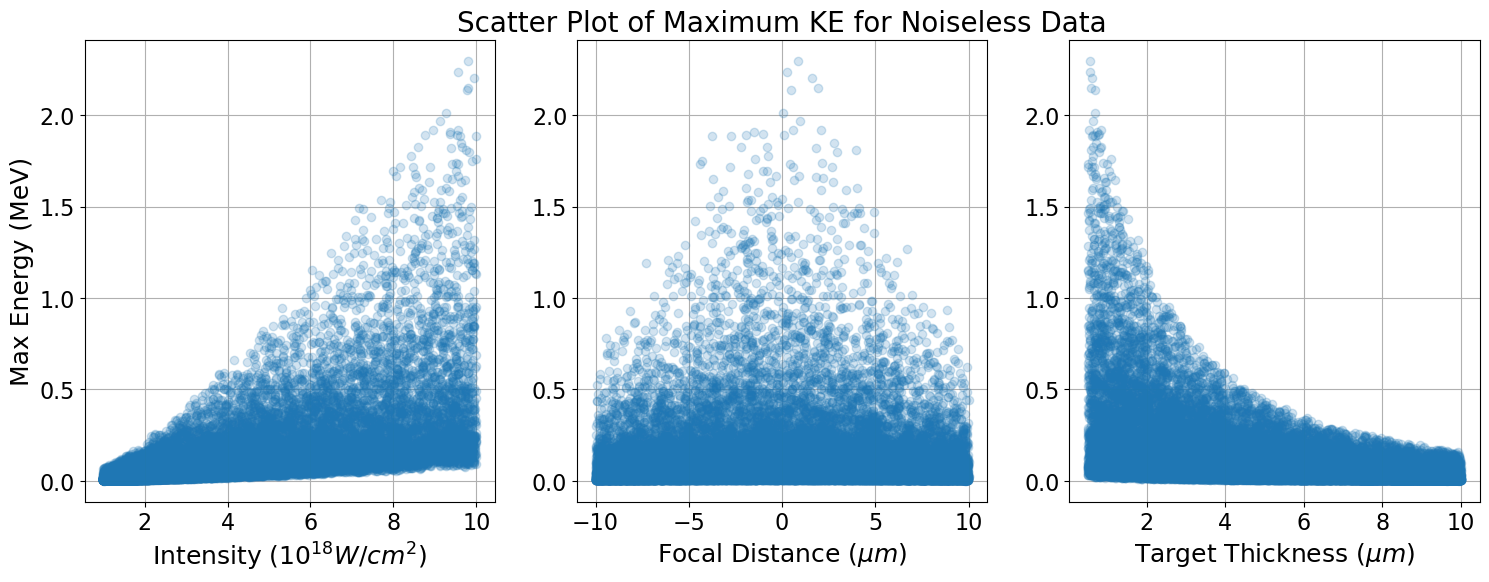

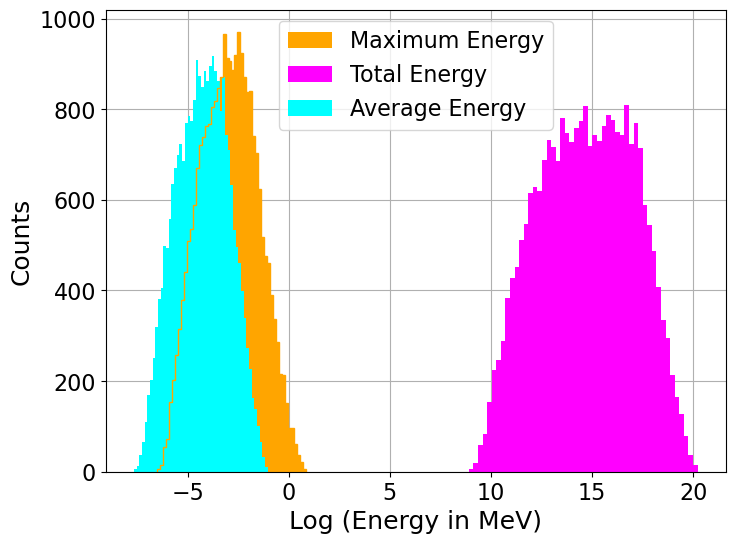

In [5]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))
for i in range(3):
    ax[i].grid()
    ax[i].set_axisbelow(True)
    ax[i].tick_params(axis='both', labelsize=16)
ax[0].set_ylabel('Max Energy (MeV)', fontsize=18)
ax[0].set_xlabel('Intensity ($10^{18} W/cm^2$)', fontsize=18)
ax[0].scatter(intensities/10**22, max_en, alpha=0.2, marker='o')
ax[1].set_xlabel('Focal Distance ($\mu m$)', fontsize=18)
ax[1].scatter(focal_distances*1e6, max_en, alpha=0.2, marker='o')
ax[2].set_xlabel('Target Thickness ($\mu m$)', fontsize=18)
ax[2].scatter(thicknesses*1e6, max_en, alpha=0.2, marker='o')
ax[1].set_title('Scatter Plot of Maximum KE for Noiseless Data', fontsize=20)
fig.savefig('plots/max_energy.eps', dpi=300)

fig, ax = plt.subplots(figsize=(8,6)) # Histogram
ax.grid()
ax.set_axisbelow(True)
bins = 50
ax.hist(np.log(max_en), bins=bins, label='Maximum Energy', color='orange')
ax.set_xlabel('Log (Energy in MeV)', fontsize=18)
ax.set_ylabel('Counts', fontsize=18)
ax.hist(np.log(tot_en), bins=bins, label='Total Energy', color='magenta')
ax.hist(np.log(avg_en), bins=bins,  label='Average Energy', color='cyan')
ax.hist(np.log(max_en), bins=bins, histtype='step', color='orange')
ax.legend(fontsize=16, loc='upper center')
ax.tick_params(axis='both', labelsize=16)
fig.savefig('plots/log_energy.eps', dpi=300)

In [6]:
fname = 'fuchs_' + str(tag) + '_points_' + str(num_points) + '_noise_' + str(pct_noise)
h5_name = fname + ".h5"

h5f = h5py.File(h5_name, 'w')
h5f.create_dataset('Intensity_(W_cm2)', data= intensities*1e-4) # Convert to W/cm^2
h5f.create_dataset('Pulse_Duration_(fs)', data= time_FWHMs*1e15) # Convert to fs
h5f.create_dataset('Target_Thickness (um)', data= thicknesses*1e6) # Convert to micron
h5f.create_dataset('Spot_Size_(FWHM um)', data=spot_sizes*1e6) # Convert to micron
h5f.create_dataset('Focal_Distance_(um)', data=focal_distances*1e6) # Convert to micron
h5f.create_dataset('Max_Proton_Energy_(MeV)', data= noisy_max_en)
h5f.create_dataset('Total_Proton_Energy_(MeV)', data = noisy_tot_en)
h5f.create_dataset('Avg_Proton_Energy_(MeV)', data = noisy_avg_en)
h5f.create_dataset('Max_Proton_Energy_Exact_(MeV)', data= max_en)
h5f.create_dataset('Total_Proton_Energy_Exact_(MeV)', data = tot_en)
h5f.create_dataset('Avg_Proton_Energy_Exact_(MeV)', data = avg_en)
h5f.create_dataset('laser_E(mJ)', data = laser_en*1e3)
h5f.create_dataset('ratio_proE_laserE_', data = efficiency)

h5f.close()

print('Storing to CSV file ...')
f = h5py.File(h5_name, 'r')
dsets = list(f.keys())
num_points = f[dsets[0]].shape[0]
num_columns = len(dsets)

data = np.zeros((num_points, num_columns))
for i in range(num_columns):
    data[:,i] = f[dsets[i]][:]

df = pd.DataFrame(data, columns=dsets)
df.to_csv(fname + '.csv', index=False)

Storing to CSV file ...


# Make NN Architecture Plot

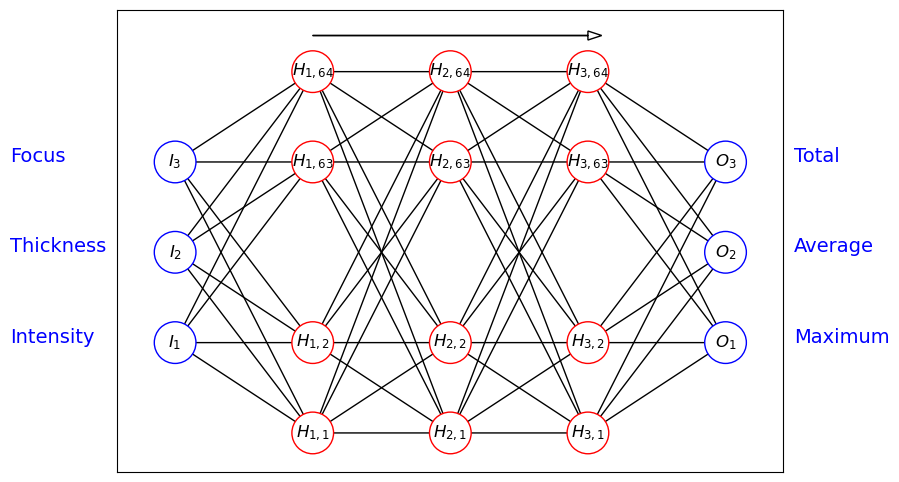

In [140]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(9, 6))
plt.arrow(-0.5, 1.2, 1, 0, head_width=0.05, head_length=0.05, fc='w', ec='k')
fsize = 14
plt.text(-1.6, -0.5, "Intensity", color='blue', fontsize=fsize)
plt.text(-1.6, 0.5, "Focus", color='blue', fontsize=fsize)
plt.text(-1.6, 0, "Thickness", color='blue', fontsize=fsize)
plt.text(1.25, -0.5, "Maximum", color='blue', fontsize=fsize)
plt.text(1.25, 0.5, "Total", color='blue', fontsize=fsize)
plt.text(1.25, 0, "Average", color='blue', fontsize=fsize)
# Define the number of nodes in each layer
layers = [3, 5, 5, 5, 3]
blanked_nodes = [5, 10, 15]

# Create a new directed graph
G = nx.DiGraph()

# Add nodes and edges for each layer
start = 0
for i in range(len(layers) - 1):
    # Add nodes for this layer and the next one
    G.add_nodes_from(range(start, start + layers[i]), layer=i)
    G.add_nodes_from(range(start + layers[i], start + layers[i] + layers[i+1]), layer=i+1)

    # Add edges between this layer and the next one
    for j in range(start, start + layers[i]):
        for k in range(start + layers[i], start + layers[i] + layers[i+1]):
            if k not in blanked_nodes and j not in blanked_nodes:
                G.add_edge(j, k)

    # Update the start for the next layer
    start += layers[i]

# Draw the graph
pos = nx.multipartite_layout(G, subset_key="layer")

# Create a dictionary for node colors and shapes
node_colors = []
node_shapes = []
edge_colors = []
for node in G.nodes():
    # Get the layer of the node
    layer = G.nodes[node]['layer']

    # If the node is in the middle layers and is not the top or bottom node, set its color to red and shape to square
    if 0 < layer < len(layers) - 1:
        edge_colors.append('red')
    else:
        edge_colors.append('blue')

for i in blanked_nodes:
    edge_colors[i] = "white"

nx.draw_networkx_nodes(G, pos, node_color='white', edgecolors=edge_colors, node_shape='o', node_size=900)
nx.draw_networkx_edges(G, pos, arrowsize=10)

# Create labels for the nodes
labels = ["$I_1$", "$I_2$", "$I_3$", 
          "$H_{1,1}$", "$H_{1,2}$", "", "$H_{1,63}$", "$H_{1,64}$", 
          "$H_{2,1}$", "$H_{2,2}$", "", "$H_{2,63}$", "$H_{2,64}$", 
          "$H_{3,1}$", "$H_{3,2}$", "", "$H_{3,63}$", "$H_{3,64}$", 
          "$O_1$", "$O_2$", "$O_3$"]
labels = dict(zip(G.nodes(), labels))

# Draw labels

nx.draw_networkx_labels(G, pos, labels=labels)
plt.subplots_adjust(left=0.13, right=0.87)
plt.savefig('plots/nn_architecture.eps', format='eps')